In [1]:
!pip install torch torchvision
!pip install sentencepiece
!pip install evaluate
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 7.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 306 kB/s 
     |████████████████████████████████| 212 kB 55.9 MB/s 
     |████████████████████████████████| 451 kB 47.4 MB/s 
     |████████████████████████████████| 182 kB 11.3 MB/s 
     |████████████████████████████████| 132 kB 69.9 MB/s 
     |████████████████████████████████| 127 kB 78.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.

In [14]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.utils.prune as prune
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
from transformers import pipeline, set_seed, AutoModelWithLMHead
from transformers import GPT2Tokenizer, GPT2Model, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSeq2SeqLM, GPT2ForSequenceClassification
from transformers import BertTokenizer
from datasets import load_dataset, load_metric
from transformers import TrainingArguments
from transformers import Trainer
import evaluate
import random
import copy

#Pruning Functions

In [3]:

class ThresholdPruning(prune.BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, threshold):
        self.threshold = threshold

    def compute_mask(self, tensor, default_mask):
        return torch.abs(tensor) > self.threshold

In [4]:
def compute_sparsity(A):
    return ((torch.numel(A) - torch.count_nonzero(A))/torch.numel(A)).item()

In [5]:
#creates a numpy array of all model weights for global pruning. 
def access_model_weights(model):
    layers = [module for module in model.modules() if isinstance(module, nn.Linear)]
    num_params = torch.tensor(0)
    for layer in layers:
        num_params += torch.prod(torch.tensor(layer.weight.shape))
    model_weights = np.empty(num_params)
    checkpoint = 0
    for layer in layers:
        span = torch.prod(torch.tensor(layer.weight.shape))
        model_weights[checkpoint:checkpoint+span] = torch.flatten(layer.weight).detach().cpu()
        checkpoint += span
    return model_weights

In [6]:
def get_preds(model_trainer):
    predictions = model_trainer.predict(tokenized_datasets["validation"])
    preds = np.argmax(predictions.predictions, axis=-1)
    return(metric.compute(predictions=preds, references=predictions.label_ids))

In [7]:
def pruning_analysis(net):
    model_weights = access_model_weights(net)
    pruning_levels = np.array([0,50,90,95,99])
    num_layers = len([module for module in net.modules() if isinstance(module, nn.Linear)])
    layers = range(num_layers)
    performance = np.empty(len(pruning_levels))
    mw = np.absolute(model_weights)
    neuron_data_by_layer = np.empty(shape = (num_layers,5))
    parameter_sparsity_by_layer = np.empty(shape = (num_layers,5))
    layer_dims = {'rows':np.empty(shape = (num_layers,5)), 'cols':np.empty(shape = (num_layers,5))}

    total_dead_neurons = np.empty(5)

    for level in tqdm(pruning_levels):
        threshhold = np.percentile(mw, level) #find threshold for global prune
        model_copy = copy.deepcopy(net) # get a new instance of the model so we dont change original
                
        #do pruning and look at sparsity
        actual_layers = [module for module in model_copy.modules() if isinstance(module, nn.Linear)]
        for layer in layers:
            parameters_to_prune = ((actual_layers[layer], 'weight'),)

            #do pruning:
            
            prune.global_unstructured(parameters_to_prune, pruning_method = ThresholdPruning, threshold = threshhold)
            

            module = actual_layers[layer]



            #look at parameter sparsity:
            parameter_sparsity_by_layer[layer, list(pruning_levels).index(level)] = compute_sparsity(module.weight_mask)





        
        #calculate accuracy:
        trainer = Trainer(
            model_copy,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            data_collator=data_collator,
            tokenizer=tokenizer,
        )
        acc = get_preds(trainer)

        performance[list(pruning_levels).index(level)] = acc['accuracy']

    '''for layer in layers:
        plt.plot(pruning_levels/100, parameter_sparsity_by_layer[layer], label = 'observed parameter sparsity')
        plt.plot(pruning_levels/100, performance, label = 'test accuracy')
        plt.title(f"Layer {layer}, matrix dimensions:{int(layer_dims['rows'][layer][0])}x{int(layer_dims['cols'][layer][0])}")
        plt.legend()
        plt.show()'''
    return parameter_sparsity_by_layer, performance, pruning_levels

        







#Bert model

In [22]:
checkpoint = "sgugger/finetuned-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

raw_datasets = load_dataset("glue", "mrpc")

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
metric = load_metric('glue', 'mrpc')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/config.json
Model config BertConfig {
  "_name_or_path": "sgugger/finetuned-bert",
  "a

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
# take a look at parameters before pruning

global_average = np.mean(np.abs(access_model_weights(model)))

layers = [module for module in model.modules() if isinstance(module, nn.Linear)]
layer_dists = np.empty(len(layers))
for i,layer in enumerate(layers):
     layer_dists[i] = torch.mean(torch.abs(layer.weight)).item()

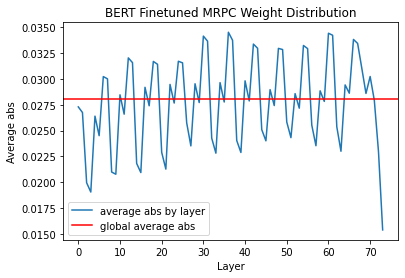

In [27]:
plt.plot(layer_dists, label = 'average abs by layer')
plt.axhline(global_average, label = 'global average abs', color = 'r')
plt.title('BERT Finetuned MRPC Weight Distribution')
plt.xlabel('Layer')
plt.ylabel('Average abs')
plt.legend()
plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



 20%|██        | 1/5 [00:05<00:22,  5.60s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8



 40%|████      | 2/5 [00:08<00:12,  4.10s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8



 60%|██████    | 3/5 [00:11<00:06,  3.48s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8



 80%|████████  | 4/5 [00:14<00:03,  3.19s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 408
  Batch size = 8



100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


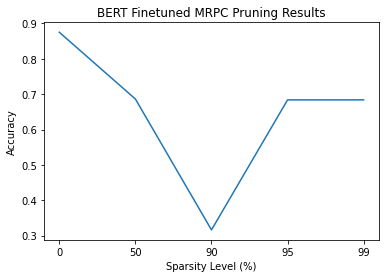

In [9]:
x,y,z = pruning_analysis(model)
plt.plot(y, label = 'model accuracy')
plt.title('BERT Finetuned MRPC Pruning Results')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Accuracy')#
plt.xticks(range(5), z)
plt.show()

In [17]:
checkpoint = "sgugger/finetuned-bert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

raw_datasets = load_dataset("glue", "wnli")

def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
metric = load_metric('glue', 'wnli')

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sgugger--finetuned-bert/snapshots/91ffe4fc44a670119a874124497f056eca12dd08/config.json
Model config BertConfig {
  "_name_or_path": "sgugger/finetuned-bert",
  "a

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


  0%|          | 0/5 [00:00<?, ?it/s]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


 20%|██        | 1/5 [00:01<00:06,  1.70s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8


 40%|████      | 2/5 [00:03<00:04,  1.58s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8


 60%|██████    | 3/5 [00:04<00:02,  1.42s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8


 80%|████████  | 4/5 [00:05<00:01,  1.36s/it]The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence1, sentence2, idx. If sentence1, sentence2, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 71
  Batch size = 8


100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


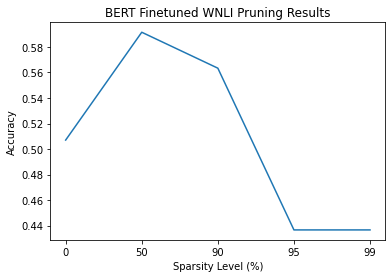

In [18]:
x,y,z = pruning_analysis(model)
plt.plot(y, label = 'model accuracy')
plt.title('BERT Finetuned WNLI Pruning Results')
plt.xlabel('Sparsity Level (%)')
plt.ylabel('Accuracy')#
plt.xticks(range(5), z)
plt.show()

#T5 Model

In [19]:
checkpoint = 'mrm8488/t5-base-finetuned-question-generation-ap'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelWithLMHead.from_pretrained(checkpoint)

raw_datasets = load_dataset('squad')

def tokenize_function(example):
    return tokenizer(example['id'],example['title'],example['context'],example['question'],example['answers'],truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments("test-trainer")
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)
metric = load_metric('squad')

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Model config T5Config {
  "_name_or_path": "mrm8488/t5-base-finetuned-question-generation-ap",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "re

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/spiece.model
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/config.json
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored 

Downloading:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--mrm8488--t5-base-finetuned-question-generation-ap/snapshots/5b3fa1afa0bba84b23b2c27eb7b4bc35aae63876/pytorch_model.bin
All model checkpoint weights were used when initializing T5ForConditionalGeneration.

All the weights of T5ForConditionalGeneration were initialized from the model checkpoint at mrm8488/t5-base-finetuned-question-generation-ap.
If your task is similar to the task the model of the checkpoint was trained on, you can already use T5ForConditionalGeneration for predictions without further training.


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/88 [00:00<?, ?ba/s]

TypeError: ignored